# PPR Crime Report Notebook

A previous analysis Notebook created a GIS point feature that includes Philadelphia Parks & Recreation (PPR) properties information for each crime that occurred this year within 5ft of a property. This feature includes all information regarding each crime’s season, the time it occurred, and crime type; this information comes with the original Philadelphia Police Department (PPD) crime data, but this information is reshaped in our analysis to meet the standards of our crime report.

This Crime Report Notebook takes the <b>crime points layer</b> - or the crimes that occurred this year within 5ft of Philadelphia Parks & Recreation properties - and creates new dataframes, or tables, from this layer in order to summarize and display our data into the <b>pie charts, overview tables, and individual site tables</b> that our annual reports consist of. 


These pie charts, overview tables, and individual site tables are exported and formatted programmatically within this report so that they can be added as separate elements into an annual report, which is expected to be developed using HTML and CSS in the future. 

In the report, each property that had a crime take place within its boundaries is given its own section in the report with tables and other graphics used to summarize/break down the crimes that occurred on the property by 1) the crime type, 2) the seasons in which the crimes occurred, and 3) the hours/time of day in which the crimes occurred. Therefore, this Notebook iterates over many PPR properties and their corresponding crimes to produce all of these elements (pie charts, various tables per property, etc.), which are saved separately to be added to the report.

This Notebook consists of 4 main sections, each with many subsections. The structure breaks up repeating report elements (such as pivot tables, site pie charts, etc.) by district so that we can tailor the code to specific districts and more quickly locate potential errors. Since this is the first year of the code's development, the analyst running the code will occassionally have to change some elements of the code to tailor it to specific districts. More information about this is in the below Setting Up section.

Currently, the output includes <b>1) hundreds of tables saved as HTML files and styled with CSS stylesheets, 2) pie charts for each district and each site within each district saved as PNGs, and 3) an overview bar graph also saved as a PNG</b>.

## Setting Up

Before running the code below, make sure that you have the feature you created in the analysis Notebook - ``PPR_Crime_5ft`` - loaded into your ArcGIS Pro project.

You also want to <b>make sure that your new project folder is set up exactly like the example 2021 one</b> used in this code. The organization of folders is important to keep track of all the graphs and tables that are being produced.

There are numerous times throughout the code where you will have to change a path or layer name. These instances have red, bolded instructions that come just before the cell you need to change. If you are ever unsure of what line within the cell the instructions are referencing, there is also a ``#CHANGE!`` note after the line that needs to be changed.

### Import libraries and set environment

The cell below imports the necessary libraries - in this case, we need pandas, a common open-source library for table and summary manipulation, the Operating System library, numpy (for statistics), ArcGIS for Python API, and ArcPy. This cell will need to be re-run every time you re-open the Notebook in order for the code to work.

In [1]:
# The import statements load each module
import pandas as pd
import os
import numpy as np

import arcgis
import arcpy # Best practice: Load arcpy last to maintain priority for namespace

In [2]:
aprx = arcpy.mp.ArcGISProject("CURRENT")
mp = aprx.listMaps('Map')[0] # first map in project - mine is titled "Map"

<b><font color='red'>IMPORTANT: CHANGE THE SECOND LINE BELOW TO THE CURRENT YEAR'S PROJECT FOLDER. 

YOU MUST KEEP THE FORWARD SLASHES ( / ), EVEN IF PASTING THE FOLDER PATH.</font></b>

In [249]:
from pathlib import Path
path = Path("X:/Projects/Special_Projects/Crime/Crime_Statistics/2021_AnnualStats_CityCouncilDistricts") #CHANGE!
print(path.absolute())

X:\Projects\Special_Projects\Crime\Crime_Statistics\2021_AnnualStats_CityCouncilDistricts


### Add new Council District field for more accurate sorting

Since our council district field is currently a text/string field and therefore will be sorted using a lexicographic sorting method (10 comes before 2 because 1 is the first character), we're going to add an integer council district field to make our manipulation of charts and graphs a bit easier below. 

<b>You only need to run this once, even if you are re-opening your Notebook and running every other cell again. Once the feature has this field added and populated, you cannot do it again.</b>

In [ ]:
arcpy.management.AddField("PPR_Crime_5ft", "COUNCILDIS", "SHORT", 5)

In [ ]:
inTable = "PPR_Crime_5ft"
fieldName = "COUNCILDIS"
expression = "!COUNCIL_DISTRICT!"
arcpy.CalculateField_management(inTable, fieldName, expression, "PYTHON")

You can check the layer's attribute table in ArcGIS Pro to make sure that this field has been added.

### Convert ``PPR_Crime_5ft`` to spatial dataframe for quicker manipulation

Our crime report filters our sites down further than the crime analysis did. We only want program sites, so we're going to set a SQL definition query to include only program sites in our report.

In [5]:
# set definition query for only program sites
for lyr in mp.listLayers("PPR_Crime_5ft"):
    lyr.definitionQuery = "PROGRAM_SITES = 'Y'"

To manipulate our data using the <a href="https://pandas.pydata.org/about/">pandas</a> library, we need to convert our feature into a spatial dataframe.

In [6]:
sdf = pd.DataFrame.spatial.from_featureclass("PPR_Crime_5ft")
sdf.shape # to find number of rows and columns

(290, 60)

Add an incident count column per PPR property (based on public name to avoid duplicates) - this is like summarizing our data in a separate table, but we're including it in our existing dataframe instead. We're counting the number of crime point incidents for each PPR property.

In [7]:
# summarize incident count
sdf['incident_count'] = sdf.groupby('PUBLIC_NAME')['PUBLIC_NAME'].transform('count')

Let's visualize the first 5 rows of our dataframe to make sure it aligns with the feature's attribute table. We should see an accurate count of crimes per property in the last column of the dataframe.

In [8]:
sdf.head(5)

,OBJECTID,Join_Count,TARGET_FID,JOIN_FID,DC_DIST,PSA,DISPATCH_DATE_TIME,DISPATCH_DATE,DISPATCH_TIME,HOUR_,DC_KEY,LOCATION_BLOCK,UCR_GENERAL,TEXT_GENERAL_CODE,POINT_X,POINT_Y,GIS_PART,GIS_CRIME,SEASON,ACTIVE_HOURS,PUBLIC_NAME,PARENT_NAME,NESTED,OFFICIAL_NAME,OFFICIAL_NAME_SOURCE,LABEL,ALIAS,DPP_ASSET_ID,ADDRESS_911,ZIP_CODE,ADDRESS_BRT,ALIAS_ADDRESS,ACREAGE,PROPERTY_CLASSIFICATION,PPR_USE,MAINTENANCE,LAND_OWNERSHIP,TENANT,ACQUISITION_DATE,FORMER_DEPARTMENT,PPR_DISTRICT,PPR_OPS_DISTRICT,COUNCIL_DISTRICT,POLICE_DISTRICT,PROGRAM_SITES,PUBLIC_MAP_DISPLAY,PUBLIC_BIG_MAP_LABELS,INTERNAL_BIG_MAP_LABELS,TPL_LAND_CLASS_ANALYSIS,CRIME_ANALYSIS,COMMENTS,GIS_CHRONOLOGY,DATE_EDITED,EDITED_BY,NOTES,BUFF_DIST,ORIG_FID,COUNCILDIS,COUNCILDIST,SHAPE,incident_count
0,2,1,2,7,25,1,2021-01-21 02:29:53.000000,2021-01-21,02:29:53,2,202125004181,1000 BLOCK W HUNTING PARK AVE,300,Robbery Firearm,-75.142065,40.016189,Part 1 Violent Crime,Robbery,Off-Season,Non-Active,Hunting Park,Hunting Park,N,,,Hunting,,845,1101 W HUNTING PARK AVE,19140,"4101 OLD YORK RD, 903 W WINGOHOCKING ST","900 HUNTING PARK AVE, 9th & Roosevelt;4101 OLD...",71.100807,REGIONAL_PARK,RECREATION_SITE,PPR,CITY,,1854,FPC,3,3,5,25,Y,Y,Y,Y,PUBLIC_DESIGNED,Y,,2017,2022-01-24,PARK_C,Feature Redesign Part 1,5.0,12,5,5,"{""x"": 2698860.0264106393, ""y"": 259536.79384239...",26
1,5,1,5,163,16,2,2021-01-08 22:15:00.000000,2021-01-08,22:15:00,22,202116000905,500 BLOCK N PAXON ST,2600,All Other Offenses,-75.223861,39.968329,Part 2 Crime,All Other Offenses,Off-Season,Active,West Mill Creek,West Mill Creek,N,West Mill Creek,Communications (2019),West Mill Creek,,1970,5100 WESTMINSTER AVE,19139,"525-53 N 52ND ST,5127-41&5100 WESTMINSTER AVE,...","51st & Reno;525-53 N 52ND ST,5127-41&5100 WEST...",5.244066,NEIGHBORHOOD_PARK,RECREATION_SITE,PPR,PRA,PPR,,REC,8,8,3,16,Y,Y,Y,Y,PUBLIC_DESIGNED,Y,,2017,2022-02-16,PARK_C,Feature Redesign Part 1,5.0,176,3,3,"{""x"": 2676457.876661226, ""y"": 241443.434359893...",37
2,6,1,6,7,25,1,2021-10-16 19:44:00.000000,2021-10-16,19:44:00,19,202125063375,900 BLOCK W Hunting Park Ave,300,Robbery No Firearm,-75.141620,40.015934,Part 1 Violent Crime,Robbery,Off-Season,Active,Hunting Park,Hunting Park,N,,,Hunting,,845,1101 W HUNTING PARK AVE,19140,"4101 OLD YORK RD, 903 W WINGOHOCKING ST","900 HUNTING PARK AVE, 9th & Roosevelt;4101 OLD...",71.100807,REGIONAL_PARK,RECREATION_SITE,PPR,CITY,,1854,FPC,3,3,5,25,Y,Y,Y,Y,PUBLIC_DESIGNED,Y,,2017,2022-01-24,PARK_C,Feature Redesign Part 1,5.0,12,5,5,"{""x"": 2698987.418872386, ""y"": 259447.652616471...",26
3,7,1,7,7,25,1,2021-09-07 04:41:00.000001,2021-09-07,04:41:00,4,202125054507,1200 BLOCK W HUNTING PARK AV,600,Thefts,-75.144901,40.016559,Part 1 Property Crime,Theft,Off-Season,Non-Active,Hunting Park,Hunting Park,N,,,Hunting,,845,1101 W HUNTING PARK AVE,19140,"4101 OLD YORK RD, 903 W WINGOHOCKING ST","900 HUNTING PARK AVE, 9th & Roosevelt;4101 OLD...",71.100807,REGIONAL_PARK,RECREATION_SITE,PPR,CITY,,1854,FPC,3,3,5,25,Y,Y,Y,Y,PUBLIC_DESIGNED,Y,,2017,2022-01-24,PARK_C,Feature Redesign Part 1,5.0,12,5,5,"{""x"": 2698062.052612886, ""y"": 259648.167963475...",26
4,9,1,9,184,15,1,2021-03-11 15:41:58.000000,2021-03-11,15:41:58,15,202115017081,1000 BLOCK ARROTT ST,400,Aggravated Assault No Firearm,-75.092263,40.021487,Part 1 Violent Crime,Aggravated Assault,Off-Season,Active,Private Alfred J Simpson Memorial Recreation C...,Private Alfred J Simpson Memorial Recreation C...,N,Private Alfred J. Simpson Memorial Recreation ...,1953 - DF Research,Simpson,,1954,1010 ARROTT ST,19124,1010 ARROTT ST,Arrott & Large;1000 ARROTT ST,4.554142,NEIGHBORHOOD_PARK,RECREATION_SITE,PPR,CITY,,1949,REC,3,3,7,15,Y,Y,Y,Y,PUBLIC_DESIGNED,Y,,2017,2022-01-24,PARK_C,Feature Redesign Part 1,5.0,197,7,7,"{""x"": 2712745.012092054, ""y"": 261881.767170816...",5


## Overview / Page 1 Tables and Charts

This section includes the code that creates our tables and charts for just the first page of the report. This page includes a <b>pivot table</b> to summarize crime counts by part (broader crime type) and district, an <b>overall pie chart</b> showing crime part by count, and an <b>overall bar graph</b> showing crime count by council district. These tables and charts represents all crimes that occurred on all PPR properties this year.

### Center Pivot Table

We're using pandas to create a pivot table from our original ``sdf`` dataframe. This pivot table summarizes incident counts by crime type and district number. We format it using pandas and then save it to an HTML, which references a CSS stylesheet, to add colors, cell borders, font, and more. 

In [9]:
# get new df with only GIS Part by incident count - same as pg 1 upper-mid table
# format pivot table as first step
part_bycount = sdf.pivot_table(values='incident_count', index=['COUNCILDIS'],
                                     columns=['GIS_PART'], aggfunc='count')

part_bycount.index.names = ['District #'] # rename index column
part_bycount.columns.name = None # get rid of extra column name
part_bycount['Total Incidents'] = part_bycount.sum(axis=1) # get total incident column
part_bycount.loc["All Districts"] = part_bycount.sum() # get toal incident bottom row
 
part_bycount.head(11) # see all 11 rows

,Part 1 Property Crime,Part 1 Violent Crime,Part 2 Crime,Total Incidents
District #,,,,
1,17,10,12,39
2,11,3,19,33
3,3,4,34,41
4,7,7,15,29
5,17,13,13,43
6,3,3,4,10
7,11,10,22,43
8,6,1,21,28
9,3,1,8,12


Our pivot table isn't perfect (would be great to merge those first two header rows and highlight max values), but now we can export it as an HTML table and style it as much as we can using our CSS style sheet that lives in the crime automation folder.

In [10]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/overviewpivot.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/OverviewPage/page1pivottable.html", 'w') as f: 
    f.write(html_string.format(table=part_bycount.to_html(classes='mystyle')))

Check the overview page folder within this year's annual stats folder for this table. It should be an HTML and will look like this:

<div>
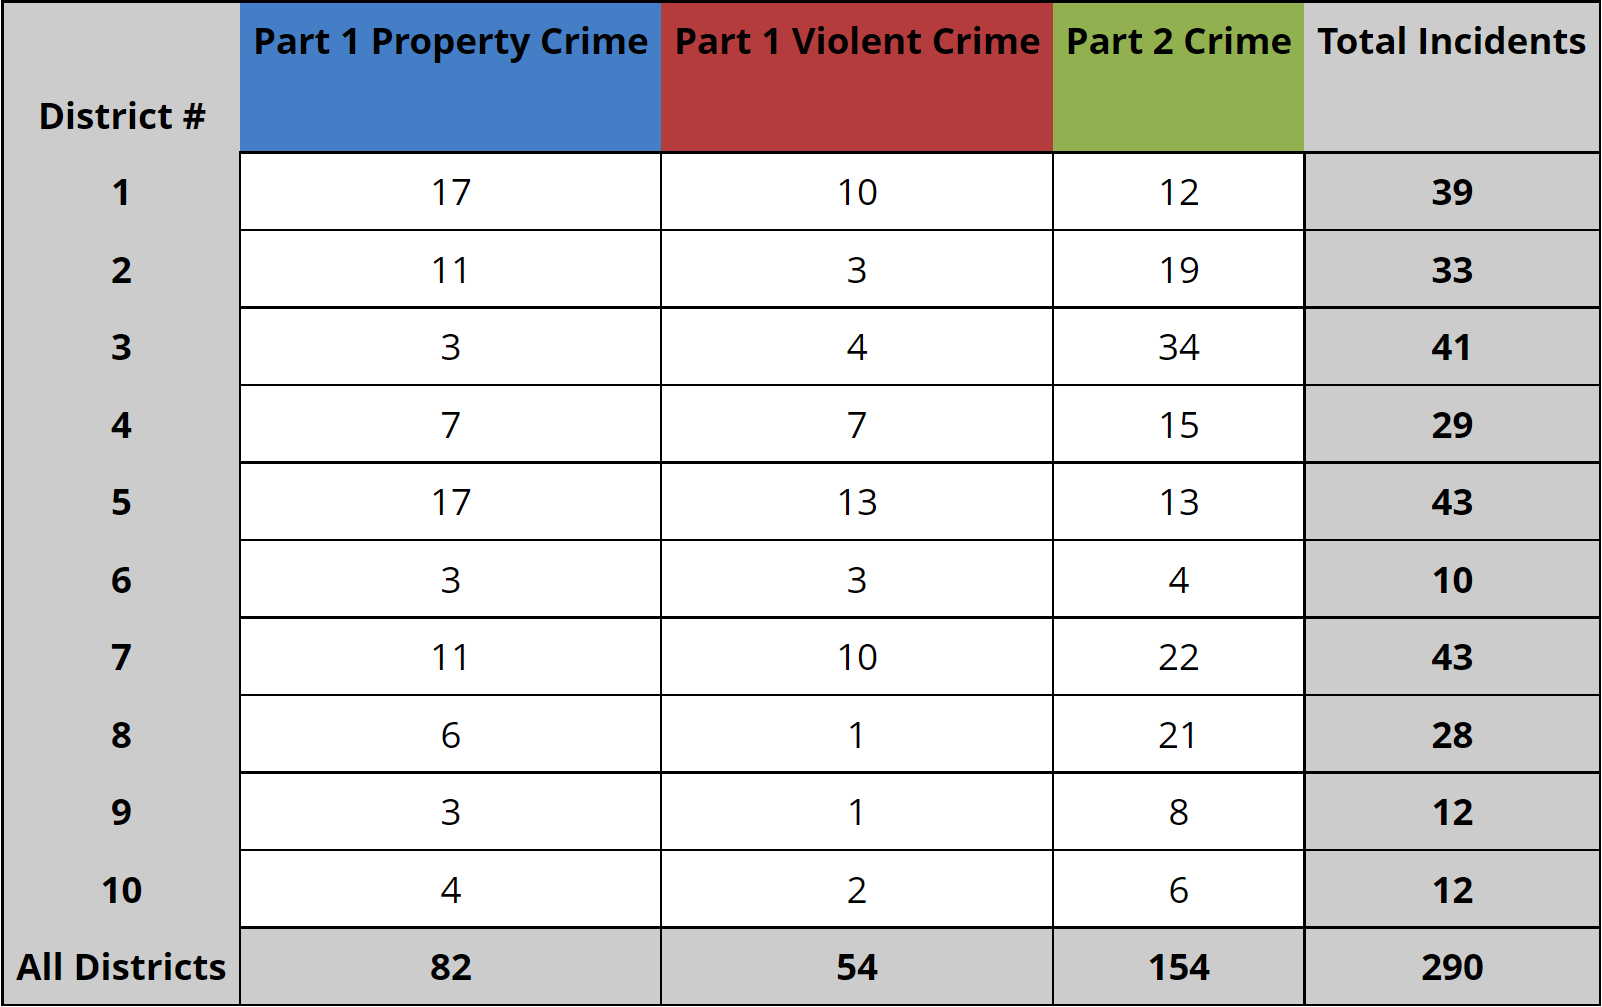
</div>

### Pie Chart

To create the overall crime pie chart, which represents crime part (broader crime type) by crime count for all properties during the entire year, we first need a separate dataframe with only our counts per part.

In [11]:
page1pie = sdf.groupby('GIS_PART')['incident_count'].agg('count').reset_index()
page1pie.head(5)

,GIS_PART,incident_count
0,Part 1 Property Crime,82
1,Part 1 Violent Crime,54
2,Part 2 Crime,154


With our new dataframe, we can now create our pie chart for the first page (all crimes).

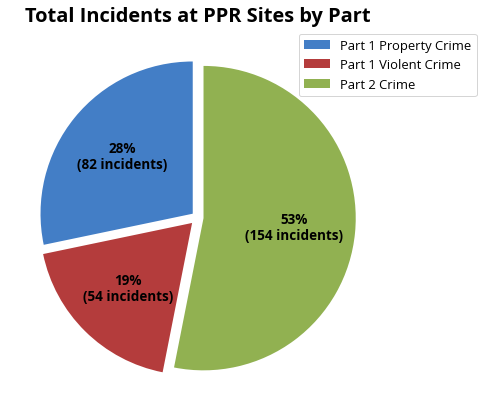

In [12]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams['font.sans-serif'] = "Open Sans"
matplotlib.rcParams['font.family'] = "sans-serif"
    
# Creating color parameters
colors = ("#437EC6", "#B43C3C", "#91B151")
explode = 0.04, 0.05, 0.04 
 
# Wedge properties
wp = { 'linewidth' : 1}
 
# Creating autocpt arguments
def autopct_format(values):
    def my_format(pct):
        total=sum(values)
        val=int(round(pct*total/100.0))
        return '{:.0f}%\n({v:d} incidents)'.format(pct, v=val)
    return my_format # creates labels text - % and # of incidents
 
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7)) # how big your overall figure (around pie chart) is
wedges, texts, autotexts = ax.pie(page1pie['incident_count'], # value - crime count
                                  autopct = autopct_format(page1pie['incident_count']),
                                  explode = explode,
                                  colors = colors,
                                  # shadow = True, - turn on if you want drop shadow
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="black")) # text color
 
# Adding legend
ax.legend(wedges, page1pie['GIS_PART'], prop={'size':13}, # last parameter is legend font size
          loc ="upper center", # text in legend
          bbox_to_anchor =(0.8, 0, 0.4, 1)) # where the legend is placed
 
plt.setp(autotexts, size = 13.5, weight ="bold") # labels
ax.set_title("Total Incidents at PPR Sites by Part", weight='bold', fontname='Open Sans', fontsize='20') # title
 
# show plot
fig.savefig(str(path) + "/OverviewPage/page1pie.png", dpi=300)

plt.show() # previews plot below

Check the overview page folder within this year's annual stats folder for this pie chart. It should be a PNG. Colors correspond to crime part and will remain consistent throughout the report.

### Bar Graph

We're creating a new table with the same information as the pivot table for the bar graph. This table and graph show the number of incidents per part (broader crime type) by council district for the entire year.

In [13]:
bargraph = sdf.groupby(['COUNCILDIS', 'GIS_PART'])['incident_count'].count().reset_index()
bargraph.head(10)

,COUNCILDIS,GIS_PART,incident_count
0,1,Part 1 Property Crime,17
1,1,Part 1 Violent Crime,10
2,1,Part 2 Crime,12
3,2,Part 1 Property Crime,11
4,2,Part 1 Violent Crime,3
5,2,Part 2 Crime,19
6,3,Part 1 Property Crime,3
7,3,Part 1 Violent Crime,4
8,3,Part 2 Crime,34
9,4,Part 1 Property Crime,7


Using the table we just created above, we're going to build and style a bar graph of crime count by council district.

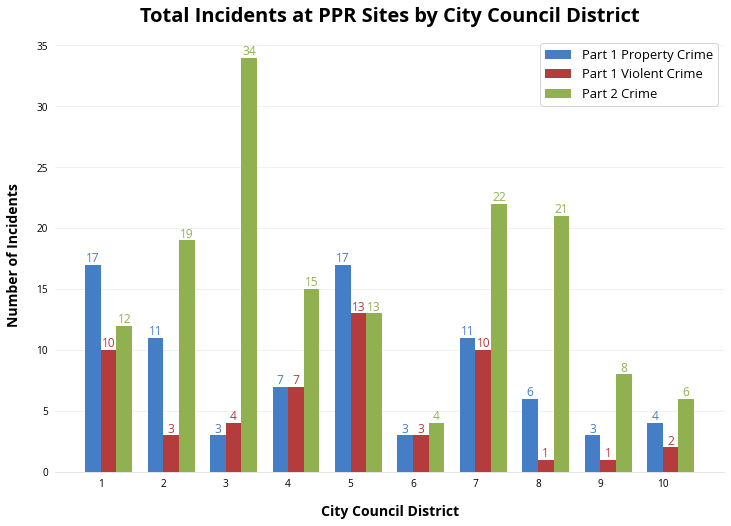

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
%matplotlib inline

matplotlib.rcParams['font.sans-serif'] = "Open Sans"
matplotlib.rcParams['font.family'] = "sans-serif"

# Create a grouped bar chart, with job as the x-axis
# and gender as the variable we're grouping on so there
# are two bars per job.
fig, ax = plt.subplots(figsize=(12, 8))

# Our x-axis. We basically just want a list
# of numbers from zero with a value for each
# of our jobs.
x = np.arange(len(bargraph.COUNCILDIS.unique()))

# Define bar width. We need this to offset the second bar.
bar_width = 0.25

# Same thing, but offset the x.
b1 = ax.bar(x, bargraph.loc[bargraph['GIS_PART'] == 'Part 1 Property Crime', 'incident_count'],
            color='#437EC6', width=bar_width, label='Part 1 Property Crime')
b1 = ax.bar(x + bar_width, bargraph.loc[bargraph['GIS_PART'] == 'Part 1 Violent Crime', 'incident_count'],
            color='#B43C3C', width=bar_width, label='Part 1 Violent Crime')
b3 = ax.bar(x + bar_width + bar_width, bargraph.loc[bargraph['GIS_PART'] == 'Part 2 Crime', 'incident_count'],
            color='#91B151', width=bar_width, label='Part 2 Crime')

# Fix the x-axes.
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(bargraph.COUNCILDIS.unique())

# Add legend.
ax.legend(prop={'size':13})

# Axis styling.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add axis and chart labels.
ax.set_xlabel('City Council District', fontname='Open Sans', fontsize='14', weight='bold', labelpad=15)
ax.set_ylabel('Number of Incidents', fontname='Open Sans', fontsize='14', weight='bold', labelpad=15)
ax.set_title('Total Incidents at PPR Sites by City Council District', pad=15, weight='bold', fontname='Open Sans', fontsize='20')

# For each bar in the chart, add a text label.
for bar in ax.patches:
  bar_value = bar.get_height()
  text = f'{bar_value:,}'
  # This will give the middle of each bar on the x-axis.
  text_x = bar.get_x() + bar.get_width() / 2
  # get_y() is where the bar starts so we add the height to it.
  text_y = bar.get_y() + bar_value
  # If we want the text to be the same color as the bar, we can
  # get the color like so:
  bar_color = bar.get_facecolor()
  # If you want a consistent color, you can just set it as a constant, e.g. #222222
  ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
          size=12)

fig.savefig(str(path) + "/OverviewPage/barchart", dpi=300)
plt.show()

Check the overview page folder within this year's annual stats folder for this graph. It should be a PNG.

## Summary Tables and Charts for Each District

We're now going to create our overview tables and pie charts as well as our individual site tables and pie charts. This section has a subsection for each of the ten City Council Districts, with each district subsection incluidng five subsections: 1) the district cover page summary analysis table, 2) the district cover page pivot table, 3) the district cover page pie chart, 4) the pie charts for each individual PPR site within the district, and 5) the 4 individual tables for each PPR site. 

### District 1

#### Main Summary Analysis Table

The main summary analysis table refers to the table at the top left of the crime report's district overview page. This table includes all site names that have had crimes occur for the entire district. It also includes the number of incidents per site, the type of each crime (``GIS_PART``) and the crime category (``GIS_CRIME``).

In [15]:
# filter original dataframe to see only District 1 sites
dis1f = sdf[sdf['COUNCILDIS'] == 1] 

# summarize incident count
dis1 = dis1f.groupby(['PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count': 'count'}).reset_index() 

# shift incident count column to second
first_column = dis1.pop('incident_count')
dis1.insert(1, 'incident_count', first_column) 

# rename columns
dis1.rename(columns = {'PUBLIC_NAME':'Site Name', 'GIS_PART':'Category', 'GIS_CRIME':'Crime Category', 'incident_count': '# of Incidents'}, inplace = True)

# add a row at the bottom for total incidents
dis1 = dis1.append(dis1.sum(numeric_only=True), ignore_index=True)
dis1['Site Name'].fillna('Total Incidents in District', inplace=True)

# fill in NAs and any decimals
dis1 = dis1.replace(np.nan, '', regex=True)
pd.set_option('precision', 0) # if having issues with decimals showing instead of whole numbers

dis1.head(50)

# save table to CSV if formatting/using in Excel:
# dis1.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

,Site Name,# of Incidents,Category,Crime Category
0,Charles Seger Park,3,Part 1 Property Crime,Theft
1,Charles Seger Park,1,Part 1 Violent Crime,Aggravated Assault
2,Columbus Square,1,Part 1 Property Crime,Motor Vehicle Theft
3,Dr Nicola Capitolo Playground,1,Part 1 Property Crime,Motor Vehicle Theft
4,Frederick Cione Playground,1,Part 1 Property Crime,Motor Vehicle Theft
5,Frederick Cione Playground,1,Part 1 Property Crime,Theft
6,Frederick Cione Playground,1,Part 1 Violent Crime,Robbery
7,Frederick Cione Playground,2,Part 2 Crime,All Other Offenses
8,Frederick Cione Playground,1,Part 2 Crime,Simple Assault
9,Hagert Street Playground,1,Part 2 Crime,Arson


We have our table content and layout from using pandas. Due to pandas' limited styling capabilities, we're going to use a CSS stylesheet to export this table as an HTML file so that it uses the fonts and cell colors that we're looking for in our report.

In [16]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/districttable.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District1/Dis_OverviewPage/dis1summarytable.html", 'w') as f: 
    f.write(html_string.format(table=dis1.to_html(classes='mystyle')))

Our output is an HTML table that looks like this:

<div>
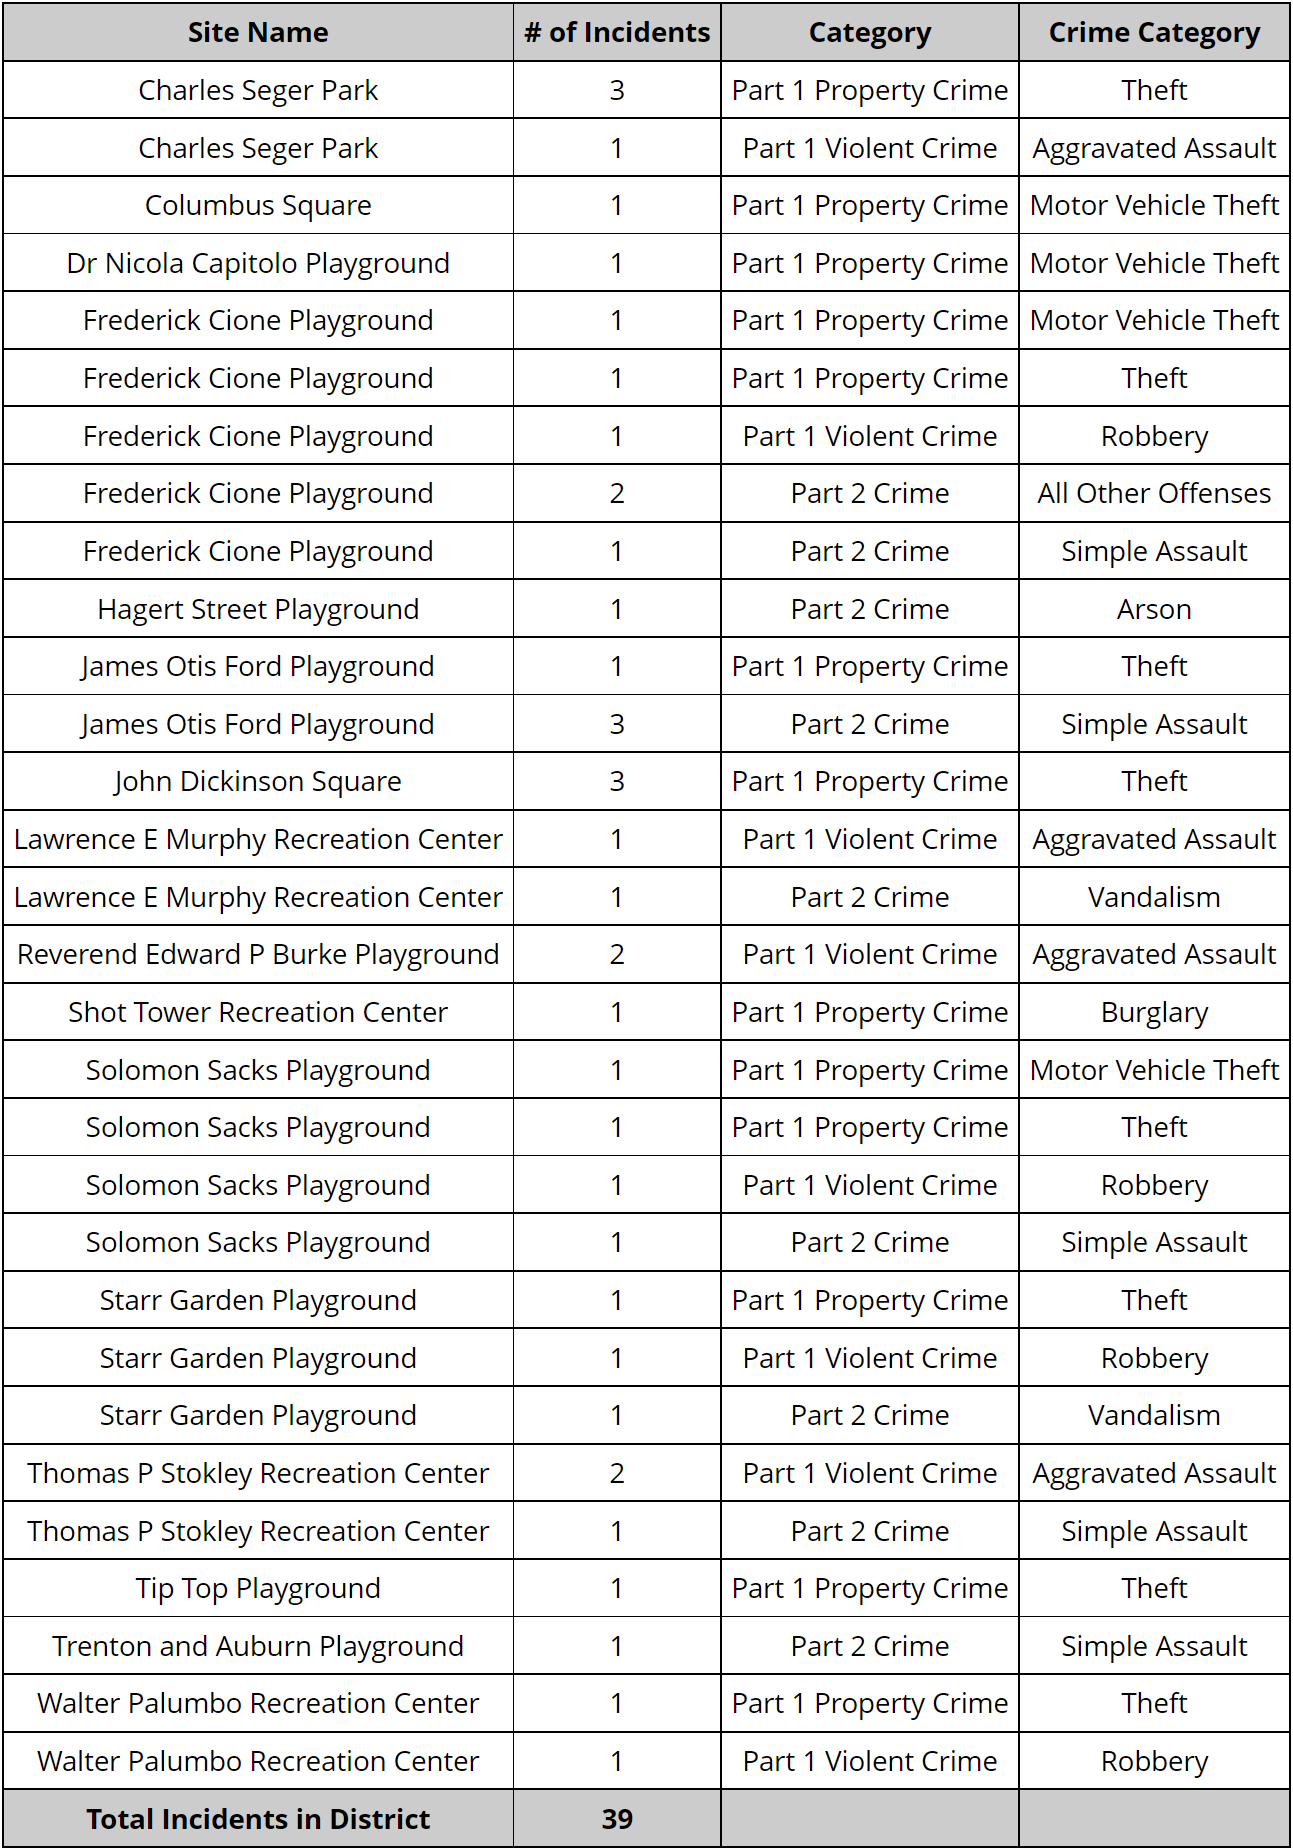
</div>

#### Main Pivot Table

The district main pivot table is the table at the top right of the crime report's district overview page. This counts the number of crimes for each crime category (rows) and crime type (columns) for each district. 

In [17]:
# shape pivot table and add total column and row
dis1_pivot = dis1f.pivot_table(values='incident_count', index=['GIS_CRIME'],
                                     columns=['GIS_PART'], aggfunc='count', margins = True, margins_name='Total', fill_value='').reset_index()

# rename the crime category column - the GIS_PART column will be hidden by our CSS when exporting
dis1_pivot.rename(columns = {'GIS_CRIME': 'Crime Category'}, inplace = True)

# remove decimal points
pd.set_option('precision', 0) 

dis1_pivot.head(10)

# dis1_crimeparttype.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

GIS_PART,Crime Category,Part 1 Property Crime,Part 1 Violent Crime,Part 2 Crime,Total
0,Aggravated Assault,,6,,6
1,All Other Offenses,,,2,2
2,Arson,,,1,1
3,Burglary,1,,,1
4,Motor Vehicle Theft,4,,,4
5,Robbery,,4,,4
6,Simple Assault,,,7,7
7,Theft,12,,,12
8,Vandalism,,,2,2
9,Total,17,10,12,39


Again, we're exporting the table that we just created using pandas to an HTML so that our styling will be applied.

In [18]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/pivotbydistrict.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District1/Dis_OverviewPage/dis1pivot.html", 'w') as f:
    f.write(html_string.format(table=dis1_pivot.to_html(classes='mystyle')))

The output should look like this:

<div>
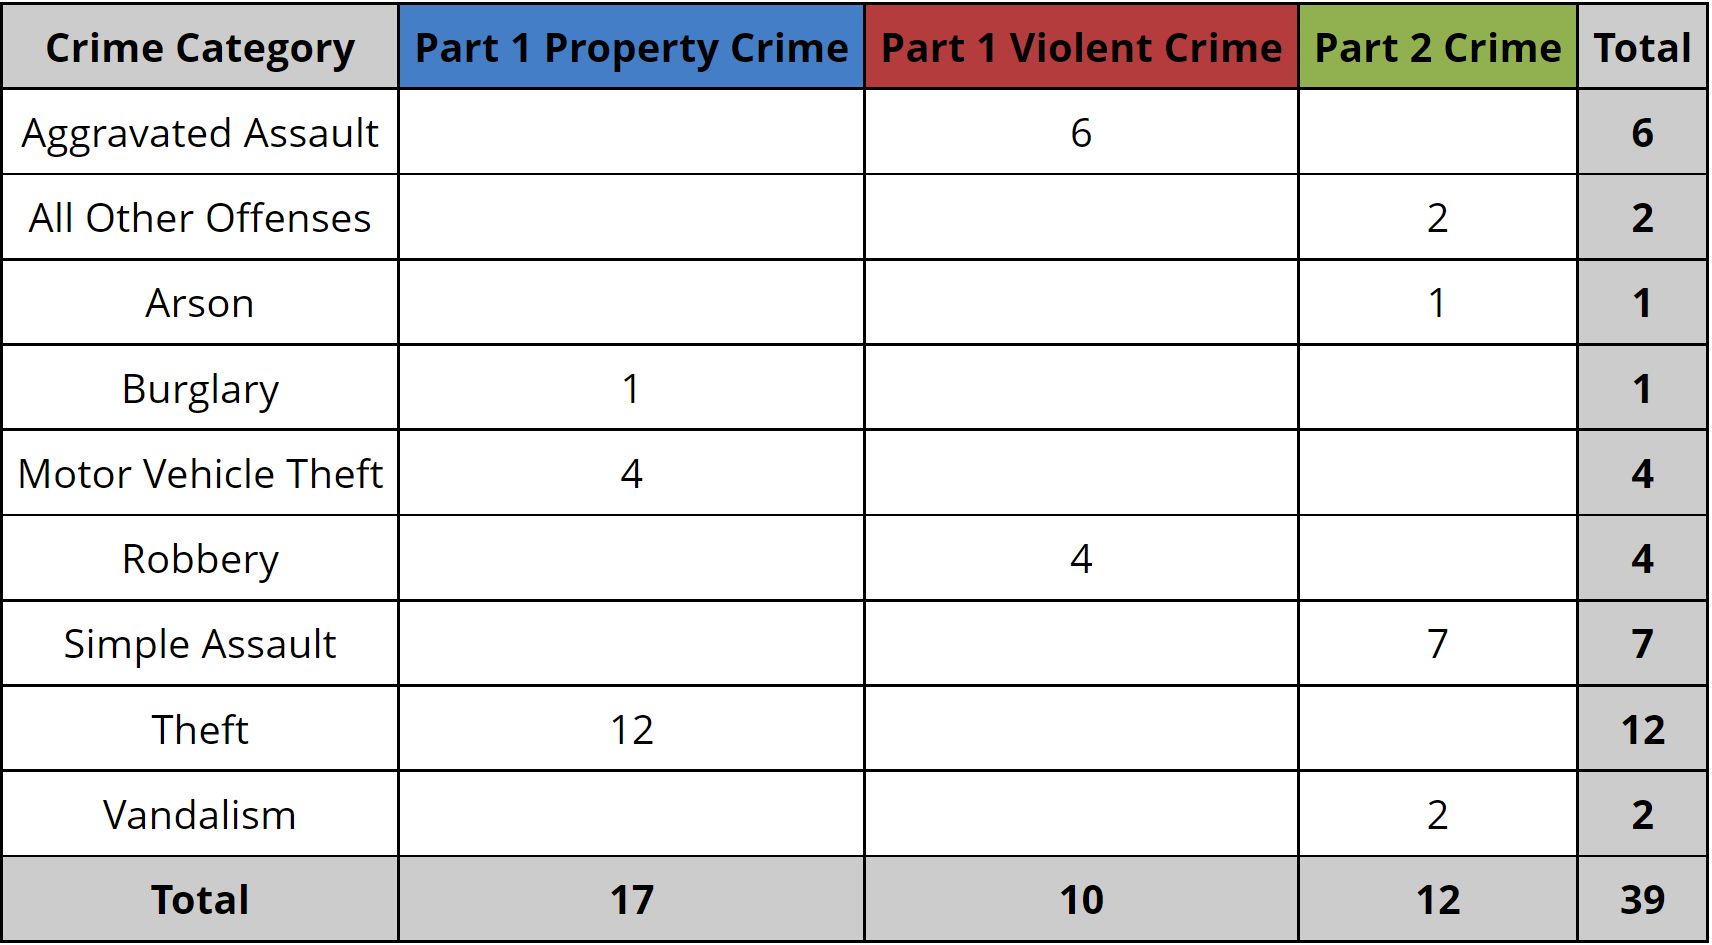
</div>

#### Pie Charts for Each Site

We can now set up our dataframe and figure for each site's pie chart. Each site with at least one crime will get its own pie chart to specify the number of crimes that occurred as well as the crime type. 

We need to set our wedge color dictionary so the pie chart can assign the correct background colors for each part. <b>You only need to set this once</b>.

In [20]:
cdict = {'Part 1 Property Crime': '#437EC6',
        'Part 1 Violent Crime': '#B43C3C',
        'Part 2 Crime': '#91B151'}

We're going to create a dataframe specifically for setting up the pie charts. Each dataframe row represents the site name, the number of incidents, and the crime type and category.

In [21]:
dis1_sites = sdf[sdf['COUNCIL_DISTRICT'] == '1'] # filters to see only District 1
# summarize incident count per site
dis1_sites = dis1_sites.groupby(['COUNCIL_DISTRICT', 'PUBLIC_NAME', 'GIS_PART']).agg({'incident_count': 'count'}).reset_index()
# set up a pivot table to count sites by GIS type/part
dis1_sites = dis1_sites.pivot_table(values='incident_count', index=['PUBLIC_NAME'],
                                    columns=['GIS_PART'], aggfunc=np.sum)
dis1_sites.reset_index(inplace=True)
print(dis1_sites.shape[0]) # checks how many rows there are - SEE BELOW FOR THE OUTPUT AFTER RUNNING.

16


^ The little number that appears above is your number of sites. Use this number to determine how many subplots should be created in the pie chart cell block.

<b><font color="red">IMPORTANT: Pay attention to how many sites are in each district (the number of rows, which should be displayed after running the cell block above). This will change the number of subplots (separate pie charts within one figure) and the overall figure size.
    
If you get an error message similar to ``IndexError: index 2 is out of bounds for axis 0 with size 2``, change the subplots numbers below. For example, if you have 16 sites, you want the subplot to have 8 rows and 2 columns for 16 total pie charts. This looks like ``plt.subplots(8, 2)``.</font>

You typically want to keep the number of columns to 2 so that the figure size parameters and the axes don't have to change too much. If you have an uneven number that is not divisible by 2 (such as 27) or your desired number of columns, you want to create one more subplot (for example, go to 28 instead of 27 - 27 divided by 2 would be 14 rows and 2 columns, which would create one empty subplot). If you change the number of columns, make sure to change this line: <font color="red">ax = axes[i // 2, i % 2]</font>, where the number 2 would be changed to the new column number.

<font color="red">A changed number of subplots/pie charts will then change the figure size (this ``figsize=(12,40)`` argument). The first number (in this example, ``12``) determines the width between the subplot/pie chart columns. A larger number sets a wider width. The second number (in this example, ``40``) determines the height between the subplots/pie charts. Again, a larger number sets more space between the subplots/pie charts.</font></b>

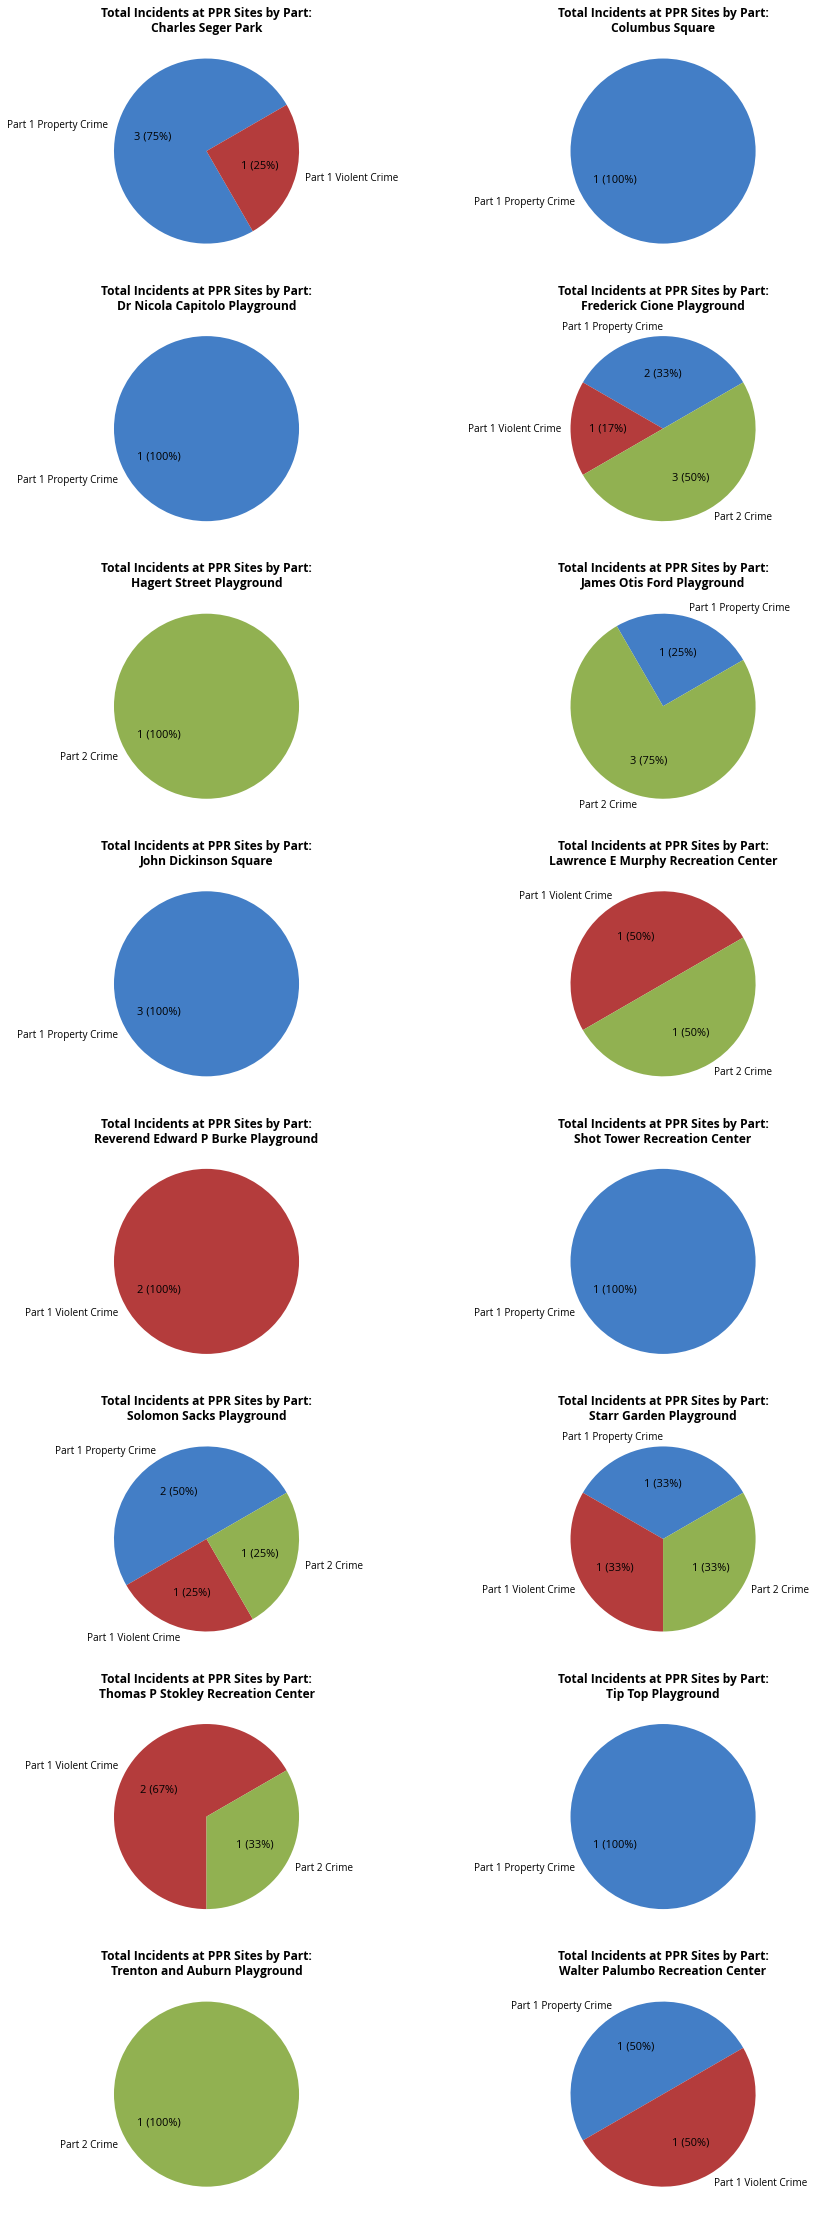

In [253]:
# import your libraries - all libraries used to generate plots need to be imported again in the cell block that generates the plot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
# -- UNCOMMENT LINES BELOW IF HAVING ISSUES WITH PATH NOT BEING RECOGNIZED AND CHANGE TO CURRENT PATH -- #
#from pathlib import Path
#path = Path("X:/Projects/Special_Projects/Crime/Crime_Statistics/2021_AnnualStats_CityCouncilDistricts") #CHANGE!

# setting the default font settings
matplotlib.rcParams['font.sans-serif'] = "Open Sans"
matplotlib.rcParams['font.family'] = "sans-serif"

wp = { 'linewidth' : 1}

# sets the number of pie charts and the size between the pie chart subplots
fig, axes = plt.subplots(8, 2, figsize=(15, 40)) # CHANGE! numbers for subplots and figsize parameters

# generate the pie charts - iterating over many rows in the dataframe
for i, (idx, row) in enumerate(dis1_sites.set_index('PUBLIC_NAME').iterrows()):
    ax = axes[i // 2, i % 2] # CHANGE! depending on subplot and figsize parameters. Can only be as big as the second numnber in the subplots parameter!
    row = row[row.gt(row.sum() * .0)]
    wedges, texts, autotexts = ax.pie(row, labels=row.index, startangle=30, autopct=lambda x: '{:.0f} ({:.0f}%)'.format((x/100)*row.sum(),x),
           colors=[cdict[row] for row in row.index], wedgeprops = wp)
    
    # sets font size for labels
    plt.setp(autotexts, size = 11)
    
    # sets title and its font size
    ax.set_title("Total Incidents at PPR Sites by Part:\n" + str(dis1_sites['PUBLIC_NAME'][i]), weight='bold', fontname='Open Sans', fontsize='12', wrap=True)

fig.subplots_adjust(wspace=.2)

# saves all pie charts to one PNG - work on saving each pie chart as a separate PNG for future
fig.savefig(str(path) + "/Districts/District1/Site_PieCharts/dis1_allsites.png", dpi=300)
plt.show()
plt.close()

#### Tables for Each Site

Each site in the crime report has 4 tables: 1) the first to show incident count by crime category (top left), 2) the second to show incident count by crime type (bottom left), 3) the third to show incident count by active/non-active hours for summer only (top right), and 4) the fourth to show incident count by active/non-active hours for off-season only (bottom right). 

The below cell blocks create and export all 4 tables per site in District 1. The ouput is 4 individual styled HTML tables per site. The files will be named after the number of the table and the site name.

We will first create another dataframe that has all the information we need for the tables in particular.

In [23]:
# filter to only include crimes that occurred in District 1
dis1_tables = sdf[sdf['COUNCIL_DISTRICT'] == '1']
# summarize incident count 
dis1_tables['incident_count_new'] = sdf.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis1_tables = dis1_tables.groupby(['COUNCIL_DISTRICT', 'PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME', 'SEASON', 'ACTIVE_HOURS']).agg({'incident_count_new': 'count'}).reset_index()
dis1_tables.head(10)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,COUNCIL_DISTRICT,PUBLIC_NAME,GIS_PART,GIS_CRIME,SEASON,ACTIVE_HOURS,incident_count_new
0,1,Charles Seger Park,Part 1 Property Crime,Theft,Off-Season,Active,2
1,1,Charles Seger Park,Part 1 Property Crime,Theft,Off-Season,Non-Active,1
2,1,Charles Seger Park,Part 1 Violent Crime,Aggravated Assault,Off-Season,Active,1
3,1,Columbus Square,Part 1 Property Crime,Motor Vehicle Theft,Summer,Active,1
4,1,Dr Nicola Capitolo Playground,Part 1 Property Crime,Motor Vehicle Theft,Off-Season,Active,1
5,1,Frederick Cione Playground,Part 1 Property Crime,Motor Vehicle Theft,Off-Season,Active,1
6,1,Frederick Cione Playground,Part 1 Property Crime,Theft,Off-Season,Active,1
7,1,Frederick Cione Playground,Part 1 Violent Crime,Robbery,Off-Season,Active,1
8,1,Frederick Cione Playground,Part 2 Crime,All Other Offenses,Off-Season,Non-Active,2
9,1,Frederick Cione Playground,Part 2 Crime,Simple Assault,Off-Season,Active,1


##### Table 1

Our first table is a pivot table that shows incident count by crime category (``GIS_CRIME``). This first cell block sets up the table, but we also want to add a total incidents row after each site for when we export individual tables for each site.

In [24]:
# create the pivot table
dis1table1 = dis1_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], aggfunc=np.sum)
dis1table1.reset_index(inplace=True)
dis1table1.head(10)

,PUBLIC_NAME,GIS_CRIME,incident_count_new
0,Charles Seger Park,Aggravated Assault,1
1,Charles Seger Park,Theft,3
2,Columbus Square,Motor Vehicle Theft,1
3,Dr Nicola Capitolo Playground,Motor Vehicle Theft,1
4,Frederick Cione Playground,All Other Offenses,2
5,Frederick Cione Playground,Motor Vehicle Theft,1
6,Frederick Cione Playground,Robbery,1
7,Frederick Cione Playground,Simple Assault,1
8,Frederick Cione Playground,Theft,1
9,Hagert Street Playground,Arson,1


Now we need to add our totals row. We want the total of all incidents for each unique site name, so we're going to create a new column for each unique site name that is in the place of our existing site name (``PUBLIC_NAME``) column. We're doing this with a ``groupby()``, where we are essentially calculating the total for each site and then joining it back to the original table in the column of our choice.

In [25]:
# create a new dataframe to calculate the total number of incidents per site
dis1table1_sum= dis1table1.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
# create a total incidents column to store the totals in
dis1table1_sum['grand_total'] ='Total Incidents'
# preparing to ensure that this total column corresponds to the correct site name in the site name columns
dis1table1.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

# create an object for our columns from the original table
dis1table1col = dis1table1[['PUBLIC_NAME', 'GIS_CRIME', 'incident_count_new']]
# concatenate our totals dataframe to match our original dataframe's columns
dis1table1final = pd.concat([dis1table1col, dis1table1_sum])
# our totals columns 
dis1table1final = dis1table1final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
# add our total rows to the crime category column, as that will be the first column we see in our exported tables
dis1table1final['GIS_CRIME'] =np.where(dis1table1final['grand_total'].isnull(),
                             dis1table1final['GIS_CRIME'],
                             dis1table1final['grand_total'])
# remove the total column - we no longer need it
dis1table1final.drop(['grand_total'],axis=1,inplace=True)
# fill any NA values in the table
dis1table1final.fillna(value=0, inplace=True)
# rename our columns for a more attractive table display
dis1table1final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME':'Crime Categories', 'incident_count_new': 'Incident Count'}, inplace = True)

dis1table1final.head(10)

,Site Name,Crime Categories,Incident Count
0,Charles Seger Park,Aggravated Assault,1
1,Charles Seger Park,Theft,3
0,Charles Seger Park,Total Incidents,4
2,Columbus Square,Motor Vehicle Theft,1
1,Columbus Square,Total Incidents,1
3,Dr Nicola Capitolo Playground,Motor Vehicle Theft,1
2,Dr Nicola Capitolo Playground,Total Incidents,1
4,Frederick Cione Playground,All Other Offenses,2
5,Frederick Cione Playground,Motor Vehicle Theft,1
6,Frederick Cione Playground,Robbery,1


We now have our table with the number of incident counts per crime category, and each site now has a total incidents number tied to it as well. Now we just need to put these into a <a href="https://www.geeksforgeeks.org/python-dictionary/">dictionary</a> so that we can iterate through each site (the key value).

We will then save each unique site's table to an HTML table.

In [26]:
dict_site_1_1 = dict(iter(dis1table1final.groupby('Site Name')))
# print(dict_site_1_1) # if wanting to see 

pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_1_1: 
    with open(str(path) + '/Districts/District1/Site_Tables/'+ str(i) + '_table1' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_1_1[i].to_html(classes='mystyle')))

In the District 1 folder, there should now be an HTML file for each site's first table. The files should look something like this, with the name of the site first and the table number second:

<div>
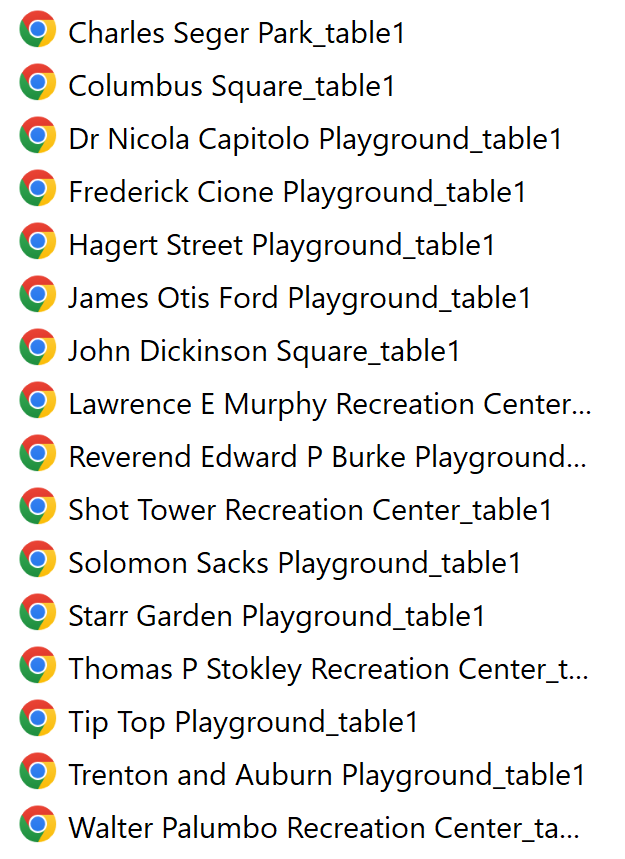
</div>

Each table should look something like this, which Frederick Cione Playground being the example in this screenshot:

<div>
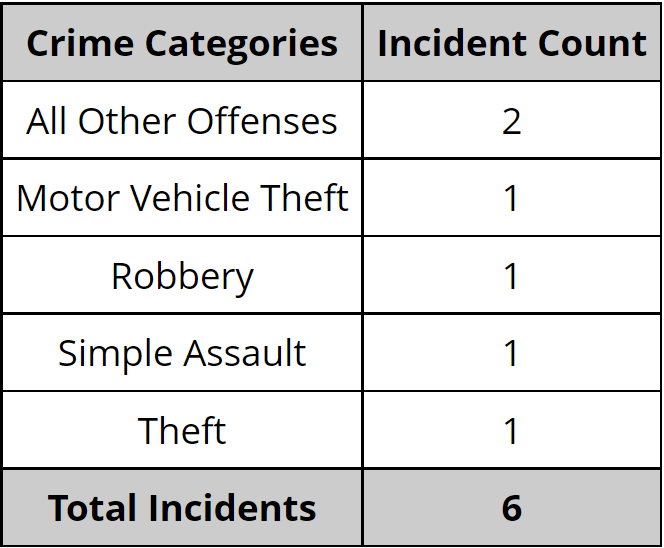
</div>

##### Table 2

Our second site pivot table is similar to our first, but it represents incident count by crime type (``GIS_PART``) instead. The layout and export steps are very similar to the first table.

In [27]:
# set up the pivot table
dis1table2 = dis1_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_PART'], aggfunc=np.sum)
dis1table2.reset_index(inplace=True)
dis1table2.head(10)

,PUBLIC_NAME,GIS_PART,incident_count_new
0,Charles Seger Park,Part 1 Property Crime,3
1,Charles Seger Park,Part 1 Violent Crime,1
2,Columbus Square,Part 1 Property Crime,1
3,Dr Nicola Capitolo Playground,Part 1 Property Crime,1
4,Frederick Cione Playground,Part 1 Property Crime,2
5,Frederick Cione Playground,Part 1 Violent Crime,1
6,Frederick Cione Playground,Part 2 Crime,3
7,Hagert Street Playground,Part 2 Crime,1
8,James Otis Ford Playground,Part 1 Property Crime,1
9,James Otis Ford Playground,Part 2 Crime,3


In [28]:
# adding our sum dataframe for the totals rows and concatenating it to the original table 2 dataframe - same as before.
dis1table2_sum= dis1table2.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
dis1table2_sum['grand_total'] ='Total Incidents'
dis1table2.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

dis1table2col = dis1table2[['PUBLIC_NAME', 'GIS_PART', 'incident_count_new']]
dis1table2final = pd.concat([dis1table2col, dis1table2_sum])
dis1table2final = dis1table2final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis1table2final['GIS_PART'] =np.where(dis1table2final['grand_total'].isnull(),
                             dis1table2final['GIS_PART'],
                             dis1table2final['grand_total'])

dis1table2final.drop(['grand_total'],axis=1,inplace=True)
dis1table2final.fillna(value=0, inplace=True)
dis1table2final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_PART': 'Crime Type', 'incident_count_new': 'Incident Count'}, inplace = True)

dis1table2final.head(10)

,Site Name,Crime Type,Incident Count
0,Charles Seger Park,Part 1 Property Crime,3
1,Charles Seger Park,Part 1 Violent Crime,1
0,Charles Seger Park,Total Incidents,4
2,Columbus Square,Part 1 Property Crime,1
1,Columbus Square,Total Incidents,1
3,Dr Nicola Capitolo Playground,Part 1 Property Crime,1
2,Dr Nicola Capitolo Playground,Total Incidents,1
4,Frederick Cione Playground,Part 1 Property Crime,2
5,Frederick Cione Playground,Part 1 Violent Crime,1
6,Frederick Cione Playground,Part 2 Crime,3


In [29]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_site_1_2 = dict(iter(dis1table2final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_1_2: 
    with open(str(path) + '/Districts/District1/Site_Tables/'+ str(i) + '_table2' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_1_2[i].to_html(classes='mystyle')))

Check the same site tables folder to make sure the tables have exported correctly.

Each table should look something like this, which Frederick Cione Playground being the example in this screenshot:

<div>
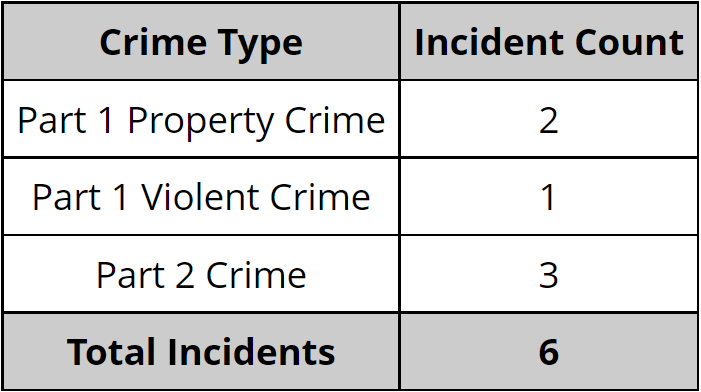
</div>

##### Table 3

Our third table is a pivot table representing SUMMER incident counts by crime category (``GIS_CRIME``) broken up into active and non-active hours. 

<b>Note that if no summer crimes occurred at a site, a table WILL NOT be generated.</b>

In [30]:
dis1table3 = dis1_tables[dis1_tables['SEASON'] == 'Summer']
dis1table3 = dis1table3.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis1table3.reset_index(inplace=True)
dis1table3.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis1table3.head(10)

ACTIVE_HOURS,PUBLIC_NAME,GIS_CRIME,Active,Non-Active
0,Columbus Square,Motor Vehicle Theft,1,0
1,James Otis Ford Playground,Simple Assault,1,0
2,James Otis Ford Playground,Theft,1,0
3,John Dickinson Square,Theft,1,0
4,Trenton and Auburn Playground,Simple Assault,1,0
5,Walter Palumbo Recreation Center,Robbery,0,1


The next steps are very similar to the first 2 site tables, but since most sites have very few summer crimes, the cell blocks for this third table may need to be modified or simply not run.

<b><font color='red'>IMPORTANT: If you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font>
    
</br>Remove only the quotation marks, the comma, and the text but not the other active hours type or the brackets. For example, ``['Active', 'Non-Active']`` becomes ``['Active']`` or ``['Non-Active']``, depending on what your error message told you.</b>

In [31]:
# adding in our dataframe for the site totals
dis1table3_sum= dis1table3.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # may need to remove one of the active hours types if there are no crimes in that season
dis1table3_sum['grand_total'] ='Total Incidents'
dis1table3.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [32]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis1table3col = dis1table3[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # may need to remove one of the active hours types if there are no crimes in that season
dis1table3final = pd.concat([dis1table3col, dis1table3_sum])
dis1table3final = dis1table3final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis1table3final['GIS_CRIME'] =np.where(dis1table3final['grand_total'].isnull(),
                             dis1table3final['GIS_CRIME'],
                             dis1table3final['grand_total'])

dis1table3final.drop(['grand_total'],axis=1,inplace=True)
dis1table3final.fillna(value=0, inplace=True)
dis1table3final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Summer'}, inplace = True)

dis1table3final.head(50)

ACTIVE_HOURS,Site Name,Crime Category - Summer,Active,Non-Active
0,Columbus Square,Motor Vehicle Theft,1,0
0,Columbus Square,Total Incidents,1,0
1,James Otis Ford Playground,Simple Assault,1,0
2,James Otis Ford Playground,Theft,1,0
1,James Otis Ford Playground,Total Incidents,2,0
3,John Dickinson Square,Theft,1,0
2,John Dickinson Square,Total Incidents,1,0
4,Trenton and Auburn Playground,Simple Assault,1,0
3,Trenton and Auburn Playground,Total Incidents,1,0
5,Walter Palumbo Recreation Center,Robbery,0,1


In [33]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_1_table3 = dict(iter(dis1table3final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_1_table3: 
    with open(str(path) + '/Districts/District1/Site_Tables/'+ str(i) + '_table3' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_1_table3[i].to_html(classes='mystyle')))

Remember that you likely will have fewer table 3s than the other tables (tables 1, 2, and 4) since sites often have  few crimes in the summer.

Each table should look something like this, with James Otis Ford being the example in this screenshot:

<div>
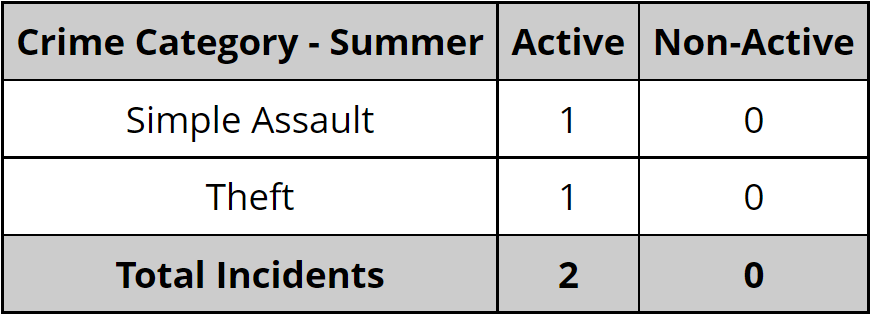
</div>

##### Table 4

Our fourth table is another pivot table representing the same information as table 3, but for off-season rather than summer. The process is very much the same, and the same potential warnings in the second cell block could come up.

<b>Note that if no off-season crimes occurred at a site, a table WILL NOT be generated.</b>

In [34]:
# set up our pivot table
dis1table4 = dis1_tables[dis1_tables['SEASON'] == 'Off-Season']
dis1table4 = dis1table4.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis1table4.reset_index(inplace=True)
dis1table4.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis1table4.head(10)

ACTIVE_HOURS,PUBLIC_NAME,GIS_CRIME,Active,Non-Active
0,Charles Seger Park,Aggravated Assault,1,0
1,Charles Seger Park,Theft,2,1
2,Dr Nicola Capitolo Playground,Motor Vehicle Theft,1,0
3,Frederick Cione Playground,All Other Offenses,0,2
4,Frederick Cione Playground,Motor Vehicle Theft,1,0
5,Frederick Cione Playground,Robbery,1,0
6,Frederick Cione Playground,Simple Assault,1,0
7,Frederick Cione Playground,Theft,1,0
8,Hagert Street Playground,Arson,1,0
9,James Otis Ford Playground,Simple Assault,1,1


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [35]:
# add the totals for each site
dis1table4_sum= dis1table4.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # might need to change
dis1table4_sum['grand_total'] ='Total Incidents'
dis1table4.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [36]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis1table4col = dis1table4[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # might need to change
dis1table4final = pd.concat([dis1table4col, dis1table4_sum])
dis1table4final = dis1table4final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis1table4final['GIS_CRIME'] =np.where(dis1table4final['grand_total'].isnull(),
                             dis1table4final['GIS_CRIME'],
                             dis1table4final['grand_total'])

dis1table4final.drop(['grand_total'],axis=1,inplace=True)
dis1table4final.fillna(value=0, inplace=True)
dis1table4final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Off-Season'}, inplace = True)

dis1table4final.head(10)

ACTIVE_HOURS,Site Name,Crime Category - Off-Season,Active,Non-Active
0,Charles Seger Park,Aggravated Assault,1,0
1,Charles Seger Park,Theft,2,1
0,Charles Seger Park,Total Incidents,3,1
2,Dr Nicola Capitolo Playground,Motor Vehicle Theft,1,0
1,Dr Nicola Capitolo Playground,Total Incidents,1,0
3,Frederick Cione Playground,All Other Offenses,0,2
4,Frederick Cione Playground,Motor Vehicle Theft,1,0
5,Frederick Cione Playground,Robbery,1,0
6,Frederick Cione Playground,Simple Assault,1,0
7,Frederick Cione Playground,Theft,1,0


In [37]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_1_table4 = dict(iter(dis1table4final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_1_table4: 
    with open(str(path) + '/Districts/District1/Site_Tables/'+ str(i) + '_table4' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_1_table4[i].to_html(classes='mystyle')))

Each table should look something like this, with Francis Cione Playground being the example in this screenshot:

<div>
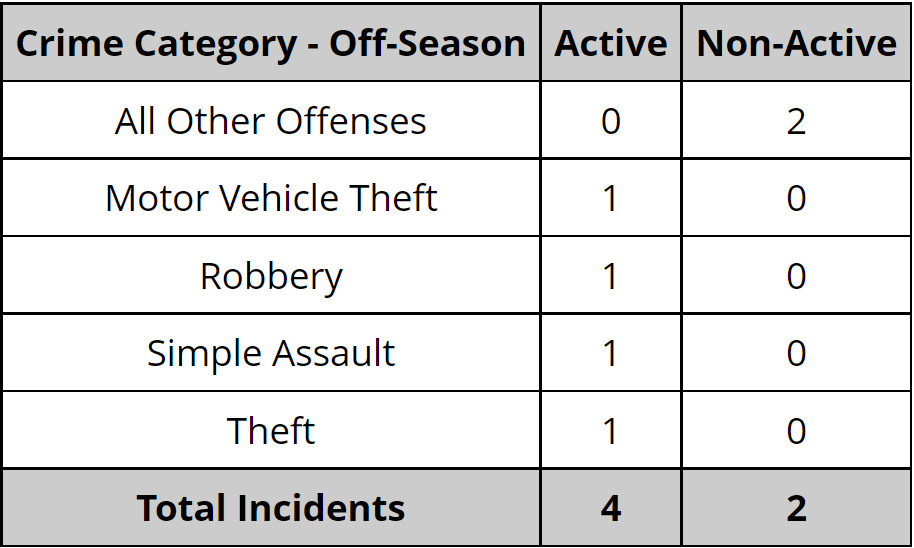
</div>

The rest of the code continues for each district. There are many improvements planned, such as 1) further automating the code to reduce changing the code (such as by writing custom functions to automatically proceed through errors) and 2) implementing new table designs to only have to generate 2 tables per site rather than 4.